In [1]:
import pdb

In [3]:
import torch
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f'{device = }')



device = 'cpu'


# 分析huggingface上的GPT2

## 导入GPT2

In [4]:
from transformers import GPT2LMHeadModel

In [5]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # gpt2: 124M; gpt2-xl 1.5B
sd_hf = model_hf.state_dict()

## 结构

In [6]:
for k, v in sd_hf.items():
    print(f'{k}\t{v.shape}')

transformer.wte.weight	torch.Size([50257, 768])
transformer.wpe.weight	torch.Size([1024, 768])
transformer.h.0.ln_1.weight	torch.Size([768])
transformer.h.0.ln_1.bias	torch.Size([768])
transformer.h.0.attn.bias	torch.Size([1, 1, 1024, 1024])
transformer.h.0.attn.masked_bias	torch.Size([])
transformer.h.0.attn.c_attn.weight	torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias	torch.Size([2304])
transformer.h.0.attn.c_proj.weight	torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias	torch.Size([768])
transformer.h.0.ln_2.weight	torch.Size([768])
transformer.h.0.ln_2.bias	torch.Size([768])
transformer.h.0.mlp.c_fc.weight	torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias	torch.Size([3072])
transformer.h.0.mlp.c_proj.weight	torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias	torch.Size([768])
transformer.h.1.ln_1.weight	torch.Size([768])
transformer.h.1.ln_1.bias	torch.Size([768])
transformer.h.1.attn.bias	torch.Size([1, 1, 1024, 1024])
transformer.h.1.attn.masked_bias	torch.S

## 参数

In [7]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

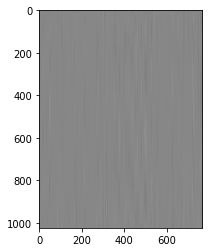

In [9]:
plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

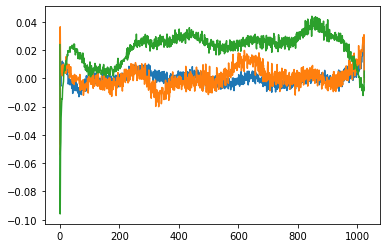

In [10]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

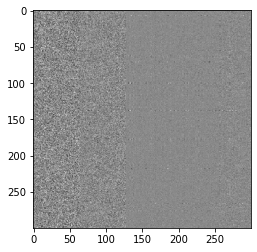

In [11]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300, :300], cmap="gray")

## 生成

In [12]:
from transformers import pipeline, set_seed

In [13]:
generator = pipeline("text-generation", model = "gpt2")

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [14]:
set_seed(42)
generator("Hello, I'm a language model", max_length = 30, num_return_sequences = 5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language modeler. I want it to help you to read and understand better the language models you're using, how they work"},
 {'generated_text': "Hello, I'm a language modeler in Google and I'm doing a lot of research on language languages. Sometimes, it is kind of awkward to"},
 {'generated_text': "Hello, I'm a language model scientist! My dream for this project is for students to be able to play with our favorite words and sentences from these"},
 {'generated_text': 'Hello, I\'m a language modeler."\n\nKhan\'s answer is that "There are probably some more fundamental questions to be answered before it'},
 {'generated_text': "Hello, I'm a language model teacher, and my focus is on making a beautiful language (and, yes, learning a language is great, if"}]

# 构建模型

GPT-2的实际实现与"Attention Is All You Need"论文有以下两点不同：
+ 调整了Layer Normalization的位置：放在attention layer之前
+ 在最后的添加了一个额外的Layer Normalization

## 结构
+ Embedding: WTE + WPE
+ Block
    + Layer Normalization
    + CasualSelfAttention
    + Residual
    + Layer Normalization
    + MLP
        + Linear 
        + GELU 
        + Linear
    + Residual
+ Layer Normalization
+ Head

## pytorch实现

In [15]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

import math

In [16]:
@dataclass
class GPTConfig:
    block_size: int = 1024 # Max sequence length
    vocab_size: int = 50257 # number of tokens: 5000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads (CausalSelfAttention)
    n_embd: int = 768 # embedding dimension

In [17]:
class CausalSelfAttention(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a `bias`, more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))
        
    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh + hs
        # e.g. in GPT-2(124M), n_heads=2, n_head=12, hs=64, so nh*hs = C = 768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

In [18]:
class MLP(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate = "tanh")
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

In [19]:
class Block(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd) # Layer Normalization
        self.attn = CausalSelfAttention(config) # CasualSelfAttention
        self.ln_2 = nn.LayerNorm(config.n_embd) # Layer Normalization
        self.mlp = MLP(config) # MLP / FFM
        
    def forward(self, x):
        x = x + self.attn(self.ln_1(x)) # residual # attention is reduce
        x = x + self.mlp(self.ln_2(x)) # residual # MLP is map
        return x

In [20]:
class GPT(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd) # Word Token Embedding
           ,wpe = nn.Embedding(config.block_size, config.n_embd) # Word Position Embedding
           ,h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]) # Block
           ,ln_f = nn.LayerNorm(config.n_embd) # Layer Normalization
            ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Head
    
    def forward(self, idx):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and position embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shpe (T)
        pos_emb = self.transformer.wpe(pos) # position embedding of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embedding of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        return logits
        
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in ("gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl")
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)
        
        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':       dict(n_layer = 12, n_head = 12, n_embd = 768 ) # 124M
           ,'gpt2-medium': dict(n_layer = 24, n_head = 16, n_embd = 1024) # 350M
           ,'gpt2-large': dict(n_layer = 36, n_head = 20, n_embd = 1280) # 774M
           ,'gpt2-xl':    dict(n_layer = 48, n_head = 25, n_embd = 1680) # 1558M        
            }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        
        # creaate a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param
        
        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        
        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just mask(buffer)
        transposed = ['.attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
                    
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

# 复制hf-GPT的checkpoints

In [21]:
model = GPT.from_pretrained('gpt2')
print("didn't crash yay!")

loading weights from pretrained gpt: gpt2
didn't crash yay!


In [22]:
for k, v in model.state_dict().items():
    print(f'The shape of {k} is {v.shape}')

The shape of transformer.wte.weight is torch.Size([50257, 768])
The shape of transformer.wpe.weight is torch.Size([1024, 768])
The shape of transformer.h.0.ln_1.weight is torch.Size([768])
The shape of transformer.h.0.ln_1.bias is torch.Size([768])
The shape of transformer.h.0.attn.bias is torch.Size([1, 1, 1024, 1024])
The shape of transformer.h.0.attn.c_attn.weight is torch.Size([2304, 768])
The shape of transformer.h.0.attn.c_attn.bias is torch.Size([2304])
The shape of transformer.h.0.attn.c_proj.weight is torch.Size([768, 768])
The shape of transformer.h.0.attn.c_proj.bias is torch.Size([768])
The shape of transformer.h.0.ln_2.weight is torch.Size([768])
The shape of transformer.h.0.ln_2.bias is torch.Size([768])
The shape of transformer.h.0.mlp.c_fc.weight is torch.Size([3072, 768])
The shape of transformer.h.0.mlp.c_fc.bias is torch.Size([3072])
The shape of transformer.h.0.mlp.c_proj.weight is torch.Size([768, 3072])
The shape of transformer.h.0.mlp.c_proj.bias is torch.Size([7

# 尝试生成

In [23]:
num_return_sequences = 5
max_length = 30

In [24]:
model.eval()
model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate=tanh)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): Layer

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate=tanh)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): Layer

In [25]:
# prefix tokens
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long) # (B, )
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)
x = tokens.to(device)
x

tensor([[15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11]])

In [26]:
# generate right now x is (B, T) wheer B = 5, T = 8
# set the seed to 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

while x.size(1) < max_length:
    with torch.no_grad():
        logits_ = model(x) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits_[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_prob here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat([x, xcol], dim=1)

In [27]:
# print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, not a science. I'm a language designer. I want to write, I want to think. I want
> Hello, I'm a language model, I use an English sentence structure, I like words over sentences.

"That's OK I'll look
> Hello, I'm a language model, not just another language." This isn't a "language model?" It's an idea. So far, what
> Hello, I'm a language model, not a programming model. I'm not a theoretical computer model - you read that right - because my ideas are
> Hello, I'm a language model, I teach myself.

I want to know more about how languages work and why they could be used.


# 训练

## 随机数初始化

In [28]:
model = GPT(GPTConfig())
model.eval()
model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate=tanh)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): Layer

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate=tanh)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): Layer

In [29]:
# generate right now x is (B, T) wheer B = 5, T = 8
# set the seed to 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

while x.size(1) < max_length:
    with torch.no_grad():
        logits_ = model(x) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits_[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_prob here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat([x, xcol], dim=1)
# print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, not a science. I'm a language designer. I want to write, I want to think. I want
> Hello, I'm a language model, I use an English sentence structure, I like words over sentences.

"That's OK I'll look
> Hello, I'm a language model, not just another language." This isn't a "language model?" It's an idea. So far, what
> Hello, I'm a language model, not a programming model. I'm not a theoretical computer model - you read that right - because my ideas are
> Hello, I'm a language model, I teach myself.

I want to know more about how languages work and why they could be used.


## 数据集

In [30]:
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [31]:
file = "./data/input.txt"
with open(file, 'r') as f:
    text = f.read()
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [32]:
# GPT2的token压缩比大概为3:1，也就是说3个字符相当于一个token

In [33]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


## batch

In [35]:
import torch
buf = torch.tensor(tokens[:24])
x = buf.view(4, 6)
print(x)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])


In [38]:
buf = torch.tensor(tokens[: 24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(f'{x = }')
print(f'{y = }')

x = tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
y = tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [41]:
text = text[:1000]
tokens = enc.encode(text)
B, T = 4,32
buf = torch.tensor(tokens[: B*T+1])
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

## 训练

In [47]:
model = GPT(GPTConfig())
model.to(device)

In [48]:
logits = model(x)
print(logits.shape)

torch.Size([4, 32, 50257])


## 修改GPT，以便支持对loss的计算

In [56]:
class GPT(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd) # Word Token Embedding
           ,wpe = nn.Embedding(config.block_size, config.n_embd) # Word Position Embedding
           ,h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]) # Block
           ,ln_f = nn.LayerNorm(config.n_embd) # Layer Normalization
            ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Head
    
    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and position embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shpe (T)
        pos_emb = self.transformer.wpe(pos) # position embedding of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embedding of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
        
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in ("gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl")
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)
        
        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':       dict(n_layer = 12, n_head = 12, n_embd = 768 ) # 124M
           ,'gpt2-medium': dict(n_layer = 24, n_head = 16, n_embd = 1024) # 350M
           ,'gpt2-large': dict(n_layer = 36, n_head = 20, n_embd = 1280) # 774M
           ,'gpt2-xl':    dict(n_layer = 48, n_head = 25, n_embd = 1680) # 1558M        
            }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        
        # creaate a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param
        
        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        
        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just mask(buffer)
        transposed = ['.attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
                    
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

In [58]:
model = GPT(GPTConfig())
model.eval()
model.to(device)
logits, loss = model(x, y)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate=tanh)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): Layer

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate=tanh)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): Layer

In [59]:
print(loss)

tensor(10.9636, grad_fn=<NllLossBackward0>)


## forward

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [61]:
for i in range(50):
    optimizer.zero_grad()
    logits, loss = model(x,y)
    loss.backward()
    optimizer.step()
    print(f"step {i+1}, loss: {loss.item()}")

step 0, loss: 10.963613510131836
step 1, loss: 6.674433708190918
step 2, loss: 4.386260509490967
step 3, loss: 2.6739444732666016
step 4, loss: 1.549945592880249
step 5, loss: 0.8876044154167175
step 6, loss: 0.5149567127227783
step 7, loss: 0.3051791787147522
step 8, loss: 0.1932266503572464
step 9, loss: 0.12472201883792877
step 10, loss: 0.08455658704042435
step 11, loss: 0.06230117008090019
step 12, loss: 0.04818561673164368
step 13, loss: 0.03832600265741348
step 14, loss: 0.032372862100601196
step 15, loss: 0.0285477451980114
step 16, loss: 0.025009455159306526
step 17, loss: 0.02159593068063259
step 18, loss: 0.018846647813916206
step 19, loss: 0.016789335757493973
step 20, loss: 0.015150988474488258
step 21, loss: 0.013715026900172234
step 22, loss: 0.012393004260957241
step 23, loss: 0.011183781549334526
step 24, loss: 0.010107061825692654
step 25, loss: 0.009168700315058231
step 26, loss: 0.008360221982002258
step 27, loss: 0.007668751757591963
step 28, loss: 0.00707532837986